1.1、提取当日日成交数据存入数据库。
1.2、提取指定小区成交数据并存入数据库。
2、从数据库提取数据。
3、获得每日成交量。
4、获得某个单价区间的成交量。
5、获得某个总价区间的成交量。
6、获得某个小区的成交信息，并将小区信息保存到csv文件中。
7、按年/月统计单价平均值。
8、按小区计算平均单价

In [1]:
#提取当日成交数据并存入数据库
from spider_lianjia.spiders.chengjiao import spyder_chengjiao,dropduplicate_db
spyder_chengjiao(1,18)
print('开始查重...')
dropduplicate_db()

开始爬取...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
爬取完毕...
开始查重...
查重完毕


In [4]:
#提取指定小区的成交数据并存入数据库
#得写一个去除暂无数据的挂牌量的代码
from spider_lianjia.spiders.chengjiao import get_chengjiao_one,insert_db,dropduplicate_db
g1=get_chengjiao_one().get_chengjiao('香周首府')
list=[]
for i in range(0,len(g1)):
    if g1[i][9]!='暂无数据':
        list.append({'title':g1[i][0],'room':g1[i][3],'area':g1[i][5],'dealDate':g1[i][11],'totalPrice':str(g1[i][1]),'unitPrice':g1[i][2],'dealCycle':g1[i][10],
        'guaPai':g1[i][9],'seller':0,'district':g1[i][7],'quyu':g1[i][6]})
insert_db(list)
dropduplicate_db()

1
2
3
4
5
查重完毕


In [1]:
 #需导入的模块
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import datetime
from numpy import random #经常有用
import re
import pymongo

#将pymongo数据转换成Dataframe
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["db_lianjia"]
mycol = mydb["chengjiao"]

x = list(mycol.find())
df=DataFrame(x)
#把没用的id删除掉
df=df.drop('_id',axis=1)    
df.drop_duplicates(inplace=True)
#把车位这一行删掉
df.drop(index=df[df['area']=='车位'].index,inplace=True) 
df['area']=df['area'].apply(lambda x: float(re.search("\d+(\.\d+)?",x).group()))
tofloat=lambda x:float(x)
df['unitPrice']=df['unitPrice'].apply(tofloat)
df['totalPrice']=df['totalPrice'].apply(tofloat)
df['dealDate']=pd.to_datetime(df['dealDate'])
# df['dealCycle']=df['dealCycle'].apply(lambda x: int(re.search('\d+',x).group()))#有些老的数据没有dealcycle
df['guaPai']=df['guaPai'].apply(lambda x: float(re.search("\d+(\.\d+)?",x).group()))



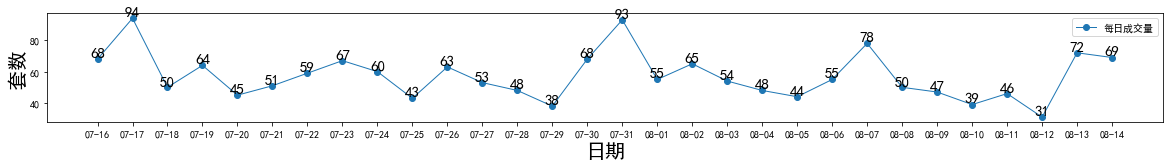

In [2]:
#获得每日成交量
df['count']=0
d=df.groupby(['dealDate']).count()['count']
d=d[-30:]

import matplotlib.pyplot as plt
plt.rcParams['font.family']=['SIMHEI']
plt.figure(figsize=(20, 2))
plt.plot(d.index,d.values,label='每日成交量',linewidth=1,marker='o')
plt.xlabel('日期',fontsize=20)
plt.ylabel('套数',fontsize=20)
plt.xticks(d.index,list(map(lambda x:x.date().strftime('%m-%d'),d.index)))
plt.legend()
for x,y in zip(d.index,d.values):
    plt.text(x, y+0.05, y, ha='center', va= 'bottom',fontsize=15)
plt.show()
 

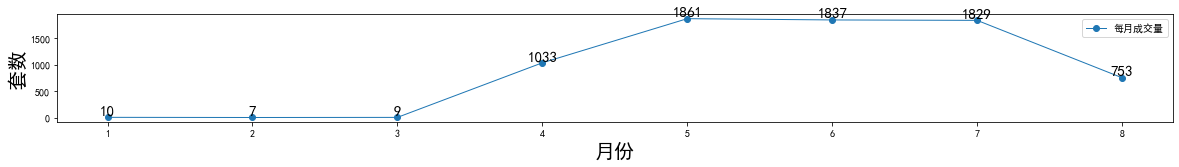

In [11]:
#2022年每月成交量，从4月份开始比较准
d=df[df['dealDate'].apply(lambda x:x.year==2022)]
d=d['title'].groupby(d['dealDate'].apply(lambda x:x.month)).count()

import matplotlib.pyplot as plt
plt.rcParams['font.family']=['SIMHEI']
plt.figure(figsize=(20, 2))
plt.plot(d.index,d.values,label='每月成交量',linewidth=1,marker='o')
plt.xlabel('月份',fontsize=20)
plt.ylabel('套数',fontsize=20)
plt.xticks(d.index)
plt.legend()
for x,y in zip(d.index,d.values):
    plt.text(x, y+0.05, y, ha='center', va= 'bottom',fontsize=15)
plt.show()

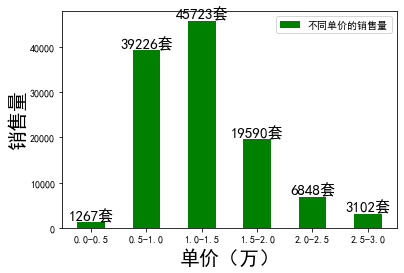

In [4]:
#获得某个单价区间的成交量
bins=[0,5000,10000,15000,20000,25000,30000]
cats=pd.cut(df['unitPrice'],bins)
X=np.arange(1,7)
Y=pd.value_counts(cats,sort=False).values
x_label=list(map(lambda x:str(x/10000)+'-'+str((x+5000)/10000),bins[:6]))
color=['red','black','peru','orchid','deepskyblue']
plt.rcParams['font.family']=['SIMHEI']
plt.bar(x=X,height=Y,align='center',width=0.5,label='不同单价的销售量',color='g')
plt.xticks(X,x_label)
plt.xlabel('单价（万）',fontsize=20)
plt.ylabel('销售量',fontsize=20)
plt.legend(loc='best')
for x,y in zip(X,Y):
    s=str(y)+'套'
    plt.text(x, y+0.05, s, ha='center', va= 'bottom',fontsize=15)
plt.show()

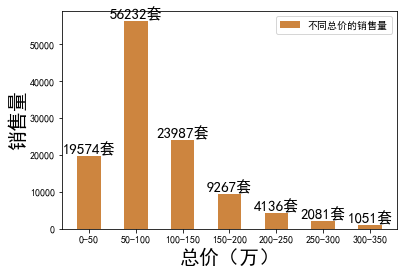

In [5]:
#获得某个总价区间的成交量
bins=[0,50,100,150,200,250,300,350]
cats=pd.cut(df['totalPrice'],bins=bins)
X=np.arange(1,8)
Y=pd.value_counts(cats,sort=False).values
x_label=list(map(lambda x:str(x)+'-'+str((x+50)),bins[:7]))
color=['red','black','peru','orchid','deepskyblue']
plt.rcParams['font.family']=['SIMHEI']
plt.bar(x=X,height=Y,align='center',width=0.5,label='不同总价的销售量',color='peru')
plt.xticks(X,x_label)
plt.xlabel('总价（万）',fontsize=20)
plt.ylabel('销售量',fontsize=20)
plt.legend(loc='best')
for x,y in zip(X,Y):
    s=str(y)+'套'
    plt.text(x, y+0.05, s, ha='center', va= 'bottom',fontsize=15)
plt.show()

In [6]:
#获得某个小区的成交信息
try:
    dwj=df[df['title'].apply(lambda x:'龙畔金泉' in x and '公寓' not in x)]
    t=dwj.sort_values(['dealDate'])
    t.describe().round(0).unstack()
except KeyError as e:
    print(e)
dwj.sort_values(by=['dealDate'])
#保存到csv文件
dwj.to_csv('data/某小区成交数据.csv',encoding='gbk')

In [14]:
#按年/月计算平均单价
#按年计算平均单价
g1=df[df['dealDate'].apply(lambda x:x.year>2015)]
g1=g1['unitPrice'].groupby(df['dealDate'].apply(lambda x:x.year)).mean()
#按月计算平均单价
g2=df['unitPrice'].groupby(df['dealDate'].apply(lambda x:x.month)).mean()
#计算某一年的月平均单价
g3=df[df['dealDate'].apply(lambda x:x.year==2019)]
g3=g3['unitPrice'].groupby(df['dealDate'].apply(lambda x:x.month)).mean()
print(g3)

dealDate
1.0     12960.588645
2.0     12389.764021
3.0     12938.823445
4.0     13081.397696
5.0     13045.945100
6.0     13168.668915
7.0     13339.144536
8.0     12690.509301
9.0     13249.853024
10.0    12987.404840
11.0    13409.388923
12.0    13825.803409
Name: unitPrice, dtype: float64


In [ ]:
#按年/月计算平均总价
#按年计算平均总价
g1=df[df['dealDate'].apply(lambda x:x.year>2015)]
g1=g1['totalPrice'].groupby(df['dealDate'].apply(lambda x:x.year)).mean()
#按月计算平均总价
g2=df['totalPrice'].groupby(df['dealDate'].apply(lambda x:x.month)).mean()
#计算某一年的月平均总价
g3=df[df['dealDate'].apply(lambda x:x.year==2019)]
g3=g3['totalPrice'].groupby(df['dealDate'].apply(lambda x:x.month)).mean()
print(g3)

In [ ]:
#按小区计算平均单价
d=df[df['dealDate'].apply(lambda x:x.year in [2020,2021,2022])]
#复杂的备用写法
#d1=df[(df['dealDate'].apply(lambda x:x.year==2020))| (df['dealDate'].apply(lambda x:x.year==2021))]
d=round(d.groupby(['title'])['unitPrice'].describe(),0)
d.columns.name='已成交'
d.to_csv('data/按小区平均单价.csv',encoding='gbk')

In [ ]:
#找出挂牌价和成交价差距大的房子
f=df[((df['guaPai']-df['totalPrice'])/df['guaPai']>0.05) & (df['dealDate'].map(lambda x:x.year)==2022)].sort_values(by=['title','dealDate'])
f['chazhi']=round((f['guaPai']-f['totalPrice'])/f['guaPai'],2)
g=df[df['dealDate'].map(lambda x:x.year==2022)].sort_values(by=['title','dealDate'])
f['title'].count()/g['title'].count()

In [ ]:
#找出各小区的某些年份的销售数量
# df.groupby(['title'])[['title']].count()
q=df[df['dealDate'].apply(lambda x:x.year>2015)]
c=q['title'].groupby([q['title'],q['dealDate'].apply(lambda x:x.year)]).count()
c.index.names=['title','year']
c

In [ ]:
#找出名字相似小区的成交情况
result=list(set(list(map(lambda x:re.search('悦泰(\w+)?',x),df['title']))))
result.remove(None)
r=[i.group() for i in result]
q=df[df['title'].apply(lambda x:x in r)]
q